## Project: Build a Traffic Sign Recognition Classifier

### Importing libraries

In [1]:
from sklearn import preprocessing
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sys
import tensorflow as tf
import csv
import glob
import pickle
import cv2

import keras
from keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import layer_utils, to_categorical
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

Using TensorFlow backend.


---
## Step 0: Load The Data

In [30]:
# Load pickled data
training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"
signnames_file = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(signnames_file, mode='r') as data:
    reader = csv.reader(data)
    next(reader)
    signnames_dict = dict(reader)  # pull in each row as a key-value pair
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [31]:
# Assert that the datasets match. 
assert(X_train.shape[0] == y_train.shape[0]), "No. of Images is not equals to number of labels"
assert(X_valid.shape[0] == y_valid.shape[0]), "No. of Images is not equals to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is not equals to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_valid.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

In [32]:

# Number of training examples
n_train = y_train.shape[0]

# Number of validation examples
n_validation = y_valid.shape[0]

# Number of testing examples.
n_test = y_test.shape[0]

# Image shape in the data set
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# Unique classes in the data set
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data Visualization

In [33]:
def shuffle(batch, seed = 0):
    m = batch.shape[0]
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_batch = batch[permutation]
    return shuffled_batch, permutation

In [34]:
def shuffle_both(batch_1, batch_2, seed = 0):
    m = batch_1.shape[0]
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_batch_1 = batch_1[permutation]
    shuffled_batch_2 = batch_2[permutation]
    return shuffled_batch_1, shuffled_batch_2

In [35]:
def create_random_mini_batch(batch, n, seed = 0):
    np.random.seed(seed)
    shuffled_batch, permutation = shuffle(batch, seed = seed)
    m = shuffled_batch.shape[0]
    ind = np.random.randint(m-n)
    mini_batch = shuffled_batch[ind:ind+n]
    indices = permutation[ind:ind+n]
    return mini_batch, indices

In [36]:
def display_images(images, labels, signnames_dict):
    '''
    This function will display images in a grid set by the sizes of c and r.
    The number of rows and columns must be high enough to accomdate the
    number of images 
    :param images: list of images to be shown in the grid
    :param c: number of columns in the grid
    :param r: number of rows in the grid
    :return: displays images as per the plt.show() function
    '''
    # Visualize transformation
    w = 14
    h = 14
    axes = []
    fig = plt.figure(figsize=(w, h))
    columns = 3
    rows = len(images)//columns + 1
    
    for i in range(1, len(images) + 1):
        img = images[i-1]
        axes.append(fig.add_subplot(rows, columns, i))
        subplot_title = signnames_dict[str(labels[i-1])]
        axes[-1].set_title(subplot_title)
        plt.imshow(img,  cmap = plt.cm.gray)
    plt.show()

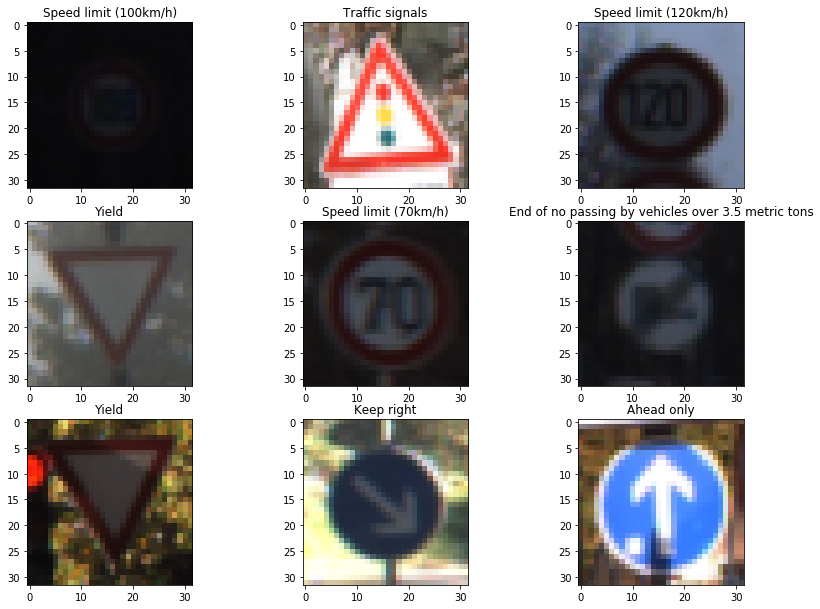

In [37]:
# Display
seed = np.random.randint(1000)

display_number = 9
mini_batch, indices = create_random_mini_batch(X_train, n = display_number, seed = seed)
labels = list(y_train[indices])
display_images(mini_batch, labels, signnames_dict)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


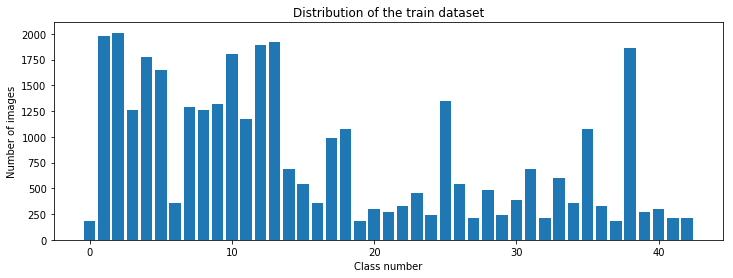

In [38]:
total_per_label = []
for l in range(n_classes):
    label = X_train[y_train == l]
    total_per_label.append(len(label))

print(total_per_label)
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), total_per_label)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

Because the lighting conditions on the signs are uniform (some are dim while others are bright), we will use historgram equalization to normalize the pixel intensity distributions at the preprocessing stage.

----

## Pre-processing

### grayscale and normalization

In [39]:
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def equalize(img):
    equal = cv2.equalizeHist(img)
    return equal

def preprocessing(img):
    gray = grayscale(img)
    #equal = equalize(gray)
    norm = gray/255
    return norm

In [40]:
# setting random seed value and shuffling the dataset
seed = np.random.randint(100000)
X_train, y_train = shuffle_both(X_train, y_train, seed = seed)

X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

# one-hot encoders for the labels
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In [41]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of valid examples = " + str(X_valid.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_valid shape: " + str(X_valid.shape))
print ("Y_valid shape: " + str(y_valid.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 34799
number of valid examples = 4410
X_train shape: (34799, 32, 32)
Y_train shape: (34799, 43)
X_valid shape: (4410, 32, 32)
Y_valid shape: (4410, 43)
X_test shape: (12630, 32, 32)
Y_test shape: (12630, 43)


### Data Augmentation

In [42]:
from keras.preprocessing.image import ImageDataGenerator

X_train = np.expand_dims(X_train, axis = -1)
X_valid = np.expand_dims(X_valid, axis = -1)
X_test = np.expand_dims(X_test, axis = -1)

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)
print(X_train.shape)

(34799, 32, 32, 1)


### Model Architecture

In [43]:
def lenet(input_shape = (32, 32, 1), classes = 43, seed = 0):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(shape=input_shape)
    
    X = X_input
    X = Conv2D(6, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2))(X)
    
    X = Conv2D(16, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2))(X)

    X = Flatten()(X)
    X = Dense(120, activation='relu', name='fc1')(X)
    #X = Dropout(0.5)(X)
    X = Dense(84, activation='relu', name='fc2')(X)
    #X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc3')(X)

    # create model
    model = Model(inputs=X_input, outputs=X, name='LeNet-5')
    
    return model

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [44]:
seed = np.random.randint(1000)
model = lenet(input_shape = (32, 32, 1), classes = 43, seed = seed)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

creating callbacks to imrpove training process.

In [45]:
checkpoint = ModelCheckpoint(filepath="call_back_checkpoint", 
                             monitor='val_loss', 
                             save_best_only=True)

stopper = EarlyStopping(monitor='val_acc', 
                        min_delta=0.0003, 
                        patience=5)

callbacks = [checkpoint]

### Model Training

In [52]:
#model.fit(X_train, y_train, epochs = 30, batch_size = 128, callbacks=callbacks)
#history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_valid, y_valid), batch_size = 64)
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=30,
                            validation_data=(X_valid, y_valid), shuffle = 1)

Epoch 1/30
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1209 - acc: 0.9626 - val_loss: 0.3309 - val_acc: 0.9134
Epoch 2/30
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1169 - acc: 0.9627 - val_loss: 0.3320 - val_acc: 0.9247
Epoch 3/30
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1156 - acc: 0.9639 - val_loss: 0.3562 - val_acc: 0.9150
Epoch 4/30
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1101 - acc: 0.9656 - val_loss: 0.4429 - val_acc: 0.9073
Epoch 5/30
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1070 - acc: 0.9671 - val_loss: 0.3745 - val_acc: 0.9213
Epoch 6/30
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1014 - acc: 0.9683 - val_loss: 0.4107 - val_acc: 0.9070
Epoch 7/30
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1016 - acc: 0.9680 - val_loss: 0.3570 - val_acc: 0.9229
Epoch 8/30
2000/2000 [==========================

If a model was previously saved, the below cell is used to load it again to skip training. 

In [ ]:
model =  keras.models.load_model('model_lenet-5')

In [53]:
preds = model.evaluate(X_valid, y_valid)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]*100))

4410/4410 [==============================] - 0s 101us/step
Loss = 0.414998436902
Test Accuracy = 92.6984127363


In [54]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]*100))

12630/12630 [==============================] - 1s 97us/step
Loss = 0.267942509659
Test Accuracy = 94.8772763281


In [ ]:
model.save("model_lenet-5")

In [ ]:
model_lenet =  keras.models.load_model('model_lenet-5')
model.summary()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Text(0.5,0,'epoch')

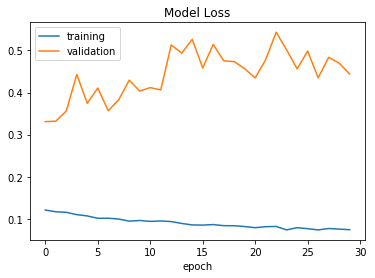

In [55]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

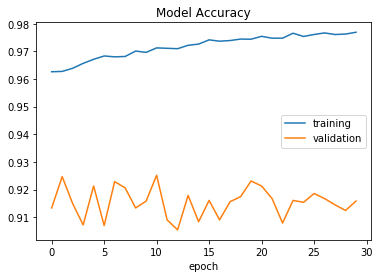

In [56]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Model Accuracy')
plt.xlabel('epoch')

## Using Inception Model

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Lambda, GlobalAveragePooling2D

# Set a couple flags for training - you can ignore these for now
freeze_flag = False  # `True` to freeze layers, `False` for full training
weights_flag = None # 'imagenet' or None
preprocess_flag = True # Should be true for ImageNet pre-trained typically

input_size = 139

inception = InceptionV3(weights=weights_flag, include_top=False,
                        input_shape=(input_size,input_size,1))

X_input_inception = Input(shape=(32, 32, 1))

# Re-sizes the input with Kera's Lambda layer & attach to cifar_input
resized_input = Lambda(lambda image: tf.image.resize_images( 
                image, (input_size, input_size)))(X_input_inception)

inp = inception(resized_input)
x = GlobalAveragePooling2D()(inp)
out = Dense(512, activation = 'relu')(x)
predictions = Dense(43, activation = 'softmax')(out)


In [ ]:
model = Model(inputs=X_input_inception, outputs=predictions, name='inceptionV3')

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs = 5, batch_size = 32)

In [ ]:
model.summary()

In [ ]:
preds = model.evaluate(X_valid, y_valid)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]*100))

In [ ]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]*100))

In [ ]:
model.save("model_inception")

---

## Test a Model on New Images

### Load and Output the Images

In [ ]:
model =  keras.models.load_model('model')

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
my_images_reader = sorted(glob.glob('data/mysigns/*.png'))
my_images = []
for i in my_images_reader:
    img = plt.imread(i)
    my_images.append(img)
    
my_images = np.array(my_images)
my_labels = [1, 22, 35, 15, 37]
display_images(my_images, my_labels, signnames_dict)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
my_images_gray = np.sum(my_images/3, axis=3, keepdims=True)
my_images_gray = my_images_gray/255
predicted_labels = []
for i in my_images_gray:
    i = np.expand_dims(i, axis=0)
    prediction = model.predict(i)
    predicted_sign = np.argmax(prediction)
    predicted_labels.append(predicted_sign)

for l in range(len(predicted_labels)):
    pred = signnames_dict[str(predicted_labels[l])]
    correct = signnames_dict[str(my_labels[l])]
    
    print("prediction: " + pred + " || correct label: " + correct)

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
performance = len(set(predicted_labels) & set(my_labels))/len(my_labels) * 100
print("performance on five user images: " + str(performance) + '%')


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
print("correct labels:   " + str(my_labels))
print("predicted labels: " + str(predicted_labels))
for i in my_images_gray:
    i = np.expand_dims(i, axis=0)
    prediction = model.predict(i)
    d = tf.nn.top_k(prediction, k=5, sorted=True, name=None)
    with tf.Session() as sess:
        top_k = sess.run(tf.nn.top_k(tf.constant(prediction), k = 5))
        print("softmax propabilities: " + str(top_k.values))
        print("softmax indices: " + str(top_k.indices))
        print("----------------------------")
        
    #print(d)
    #print(prediction)

In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))